# COMMERCIAL OPTIMIZATION. Seasonality

**Objective Sprint 4**  
Adjust business strategy (pricing, promotions, services) based on tourism trends from INE (Spain’s National Statistics Institute) to better match traveler demand.

• Is it necessary to adjust our offerings to `traveler's profile` and the **`demand for overnight stays`** in the cities where we are present, considering the official figures on origin, months of visit, and average overnight stays per autonomous city?

**Description and characteristics of dataset**  
External data:  
[Hotel occupancy survey from the National Institute of Statistics](https://www.ine.es/dynt3/inebase/es/index.htm?padre=238&dh=1)

In [40]:
# import libraries 
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

In [61]:
# file path
file_path = r"../Data/INE_Encuesta_de_ocupación_hotelera_2074.csv"

df = pd.read_csv(file_path, sep=";", encoding="utf-8-sig")

df.head()

,Totales Territoriales,Comunidades y Ciudades Autónomas,Provincias,Viajeros y pernoctaciones,Residencia: Nivel 1,Residencia: Nivel 2,Periodo,Total
0,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M02,6.539.960
1,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M01,5.776.075
2,Total Nacional,NaN,NaN,Viajero,Total,NaN,2024M12,6.553.489
3,Total Nacional,NaN,NaN,Viajero,Total,NaN,2024M11,7.171.221
4,Total Nacional,NaN,NaN,Viajero,Total,NaN,2024M10,10.774.309


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131880 entries, 0 to 131879
Data columns (total 8 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   Totales Territoriales             131880 non-null  object
 1   Comunidades y Ciudades Autónomas  129996 non-null  object
 2   Provincias                        94200 non-null   object
 3   Viajeros y pernoctaciones         131880 non-null  object
 4   Residencia: Nivel 1               131880 non-null  object
 5   Residencia: Nivel 2               87920 non-null   object
 6   Periodo                           131880 non-null  object
 7   Total                             131870 non-null  object
dtypes: object(8)
memory usage: 8.0+ MB


In [43]:
# Get distinct values and their counts for each column (from 2022 onwards)
print("Distinct value counts for each column (from 2022):\n")
for col in df.columns:
    print(f"Column: {col}")
    print(df[col].value_counts(dropna=False), "\n")

Distinct value counts for each column (from 2022):

Column: Totales Territoriales
Totales Territoriales
Total Nacional    131880
Name: count, dtype: int64 

Column: Comunidades y Ciudades Autónomas
Comunidades y Ciudades Autónomas
07 Castilla y León                18840
01 Andalucía                      16956
08 Castilla - La Mancha           11304
09 Cataluña                        9420
12 Galicia                         9420
16 País Vasco                      7536
10 Comunitat Valenciana            7536
02 Aragón                          7536
05 Canarias                        5652
11 Extremadura                     5652
06 Cantabria                       3768
04 Balears, Illes                  3768
03 Asturias, Principado de         3768
13 Madrid, Comunidad de            3768
14 Murcia, Región de               3768
15 Navarra, Comunidad Foral de     3768
17 Rioja, La                       3768
18 Ceuta                           1884
NaN                                1884
19 Melill

In [44]:
# Clean and convert 'Total' column to float
df['Total'] = (
    df['Total']
    .astype(str)
    .str.replace('.', '', regex=False)
    .replace('', np.nan)
    .astype(float)
)

# Drop rows with Totals for both travellers origen and rename
df = df.dropna(subset=['Residencia: Nivel 2'])
df = df.rename(columns={'Residencia: Nivel 2': 'Traveler Origin'})

# Drop column same value for all rows
df = df.drop(columns=['Residencia: Nivel 1'])

In [45]:
df.isna().sum()

Totales Territoriales                   0
Comunidades y Ciudades Autónomas     1256
Provincias                          25120
Viajeros y pernoctaciones               0
Traveler Origin                         0
Periodo                                 0
Total                                  57
dtype: int64

In [46]:
# Define full province names
target_provinces = [
    "29 Málaga",
    "41 Sevilla",
    "07 Balears, Illes",
    "08 Barcelona",
    "17 Girona",
    "46 Valencia/València",
    "28 Madrid"
]

# Clean 'Provincias' column
df['Provincias'] = df['Provincias'].astype(str).str.strip()

# Apply both filters sequentially on df
df_filtered = df[
    df['Provincias'].isin(target_provinces) &
    (df['Periodo'].str[:4].astype(int) >= 2022)
].copy()

In [47]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1064 entries, 15386 to 108995
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Totales Territoriales             1064 non-null   object 
 1   Comunidades y Ciudades Autónomas  1064 non-null   object 
 2   Provincias                        1064 non-null   object 
 3   Viajeros y pernoctaciones         1064 non-null   object 
 4   Traveler Origin                   1064 non-null   object 
 5   Periodo                           1064 non-null   object 
 6   Total                             1064 non-null   float64
dtypes: float64(1), object(6)
memory usage: 66.5+ KB


In [51]:
# Separate into travelers and overnight stays
df_travelers = df_filtered[df_filtered['Viajeros y pernoctaciones'] == 'Viajero'].copy()
df_stays = df_filtered[df_filtered['Viajeros y pernoctaciones'] == 'Pernoctaciones'].copy()

# Rename 'Total' to reflect its meaning in each DataFrame
df_travelers.rename(columns={'Total': 'Total Travelers'}, inplace=True)
df_stays.rename(columns={'Total': 'Total Overnight Stays'}, inplace=True)

for d in [df_travelers, df_stays]:
    d['Year'] = d['Periodo'].str[:4].astype(int)
    d['Month'] = d['Periodo'].str[5:].astype(int)

In [52]:
df_travelers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532 entries, 15386 to 108053
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Totales Territoriales             532 non-null    object 
 1   Comunidades y Ciudades Autónomas  532 non-null    object 
 2   Provincias                        532 non-null    object 
 3   Viajeros y pernoctaciones         532 non-null    object 
 4   Traveler Origin                   532 non-null    object 
 5   Periodo                           532 non-null    object 
 6   Total Travelers                   532 non-null    float64
 7   Year                              532 non-null    int64  
 8   Month                             532 non-null    int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 41.6+ KB


In [53]:
df_stays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532 entries, 16328 to 108995
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Totales Territoriales             532 non-null    object 
 1   Comunidades y Ciudades Autónomas  532 non-null    object 
 2   Provincias                        532 non-null    object 
 3   Viajeros y pernoctaciones         532 non-null    object 
 4   Traveler Origin                   532 non-null    object 
 5   Periodo                           532 non-null    object 
 6   Total Overnight Stays             532 non-null    float64
 7   Year                              532 non-null    int64  
 8   Month                             532 non-null    int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 41.6+ KB


In [54]:
monthly_trend = df_travelers.groupby(['Provincias', 'Year', 'Month'])['Total Travelers'].sum().reset_index()
print(monthly_trend.head())

          Provincias  Year  Month  Total Travelers
0  07 Balears, Illes  2022      1          42131.0
1  07 Balears, Illes  2022      2          92624.0
2  07 Balears, Illes  2022      3         202458.0
3  07 Balears, Illes  2022      4         627500.0
4  07 Balears, Illes  2022      5        1378650.0


In [55]:
# Merge datasets on common keys (Region, Year, Month, Traveler Origin)
df_merged = pd.merge(
    df_travelers, 
    df_stays, 
    on=['Comunidades y Ciudades Autónomas', 'Provincias', 'Traveler Origin', 'Year', 'Month']
)

# Calculate average stay duration
df_merged['Avg Stay Duration'] = df_merged['Total Overnight Stays'] / df_merged['Total Travelers']

# Create final DataFrame by copying the selected columns
df_final = df_merged.loc[:, [
    'Comunidades y Ciudades Autónomas', 
    'Provincias', 
    'Traveler Origin', 
    'Year', 
    'Month', 
    'Total Travelers', 
    'Total Overnight Stays', 
    'Avg Stay Duration'
]].copy()  # Using .copy() ensures we're working with a new DataFrame

# Convert Month to categorical for better visualization
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
df_final['Month'] = df_final['Month'].map(month_map)

In [56]:
df_final

,Comunidades y Ciudades Autónomas,Provincias,Traveler Origin,Year,Month,Total Travelers,Total Overnight Stays,Avg Stay Duration
0,01 Andalucía,29 Málaga,Residentes en España,2025,Feb,153408.0,302301.0,1.970569
1,01 Andalucía,29 Málaga,Residentes en España,2025,Jan,97146.0,184578.0,1.900006
2,01 Andalucía,29 Málaga,Residentes en España,2024,Dec,120354.0,246894.0,2.051398
3,01 Andalucía,29 Málaga,Residentes en España,2024,Nov,141204.0,280232.0,1.984590
4,01 Andalucía,29 Málaga,Residentes en España,2024,Oct,164584.0,356124.0,2.163783
...,...,...,...,...,...,...,...,...
527,"13 Madrid, Comunidad de",28 Madrid,Residentes en el Extranjero,2022,May,460034.0,1110766.0,2.414530
528,"13 Madrid, Comunidad de",28 Madrid,Residentes en el Extranjero,2022,Apr,396769.0,1023461.0,2.579488
529,"13 Madrid, Comunidad de",28 Madrid,Residentes en el Extranjero,2022,Mar,323693.0,815168.0,2.518337
530,"13 Madrid, Comunidad de",28 Madrid,Residentes en el Extranjero,2022,Feb,236771.0,588508.0,2.485558


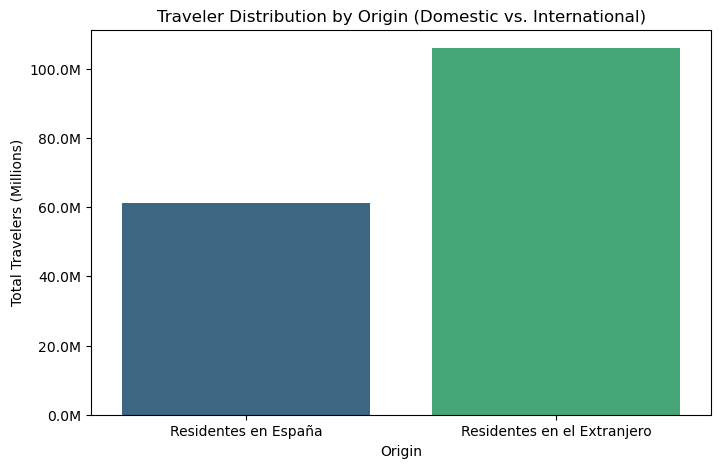

In [57]:
origin_dist = df_final.groupby('Traveler Origin')['Total Travelers'].sum().reset_index()

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=origin_dist, x='Traveler Origin', y='Total Travelers', palette='viridis')

ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M')
)

plt.title("Traveler Distribution by Origin (Domestic vs. International)")
plt.ylabel("Total Travelers (Millions)")
plt.xlabel("Origin")
plt.show()

In [58]:
origin_dist

,Traveler Origin,Total Travelers
0,Residentes en España,61317577.0
1,Residentes en el Extranjero,105995447.0


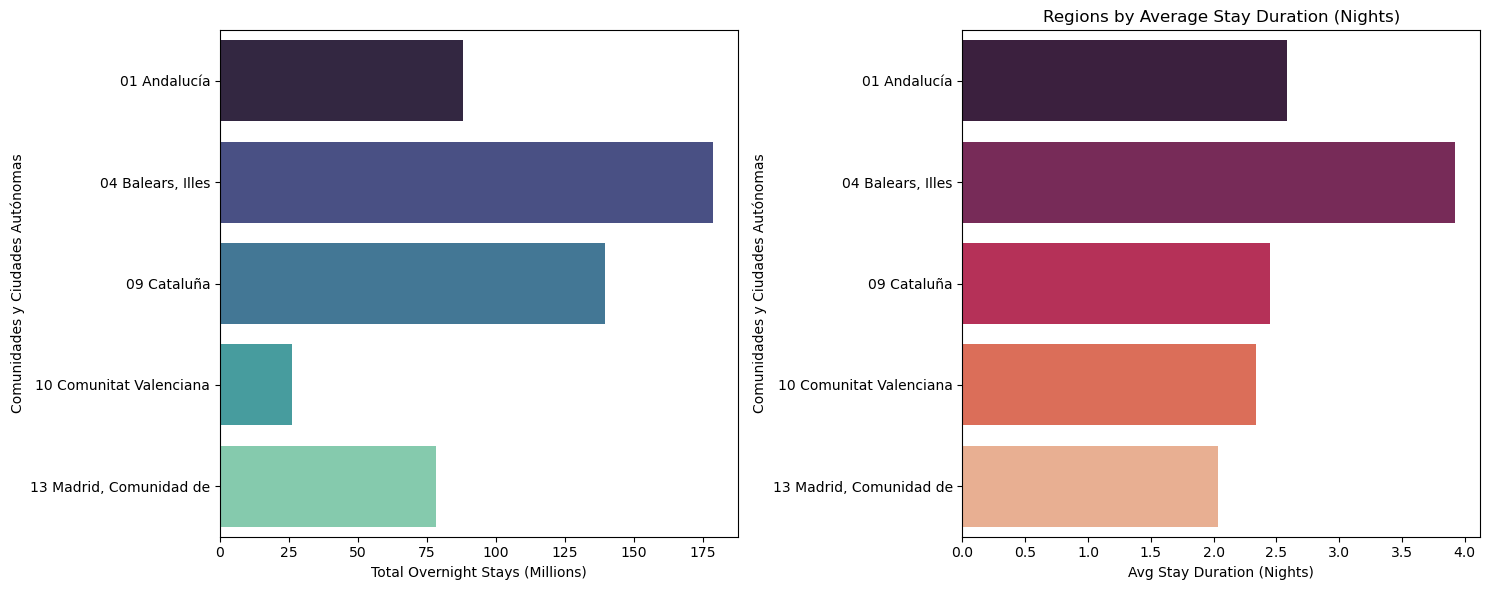

In [59]:
regional_stays = df_final.groupby('Comunidades y Ciudades Autónomas')['Total Overnight Stays'].sum()
regional_avg_stay = df_final.groupby('Comunidades y Ciudades Autónomas')['Avg Stay Duration'].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(y=regional_stays.index, x=regional_stays.values / 1_000_000, ax=ax1, palette='mako')
ax1.set_xlabel("Total Overnight Stays (Millions)")  

sns.barplot(y=regional_avg_stay.index, x=regional_avg_stay.values, ax=ax2, palette='rocket')
ax2.set_title("Regions by Average Stay Duration (Nights)")
ax2.set_xlabel("Avg Stay Duration (Nights)")
plt.tight_layout()
plt.show()

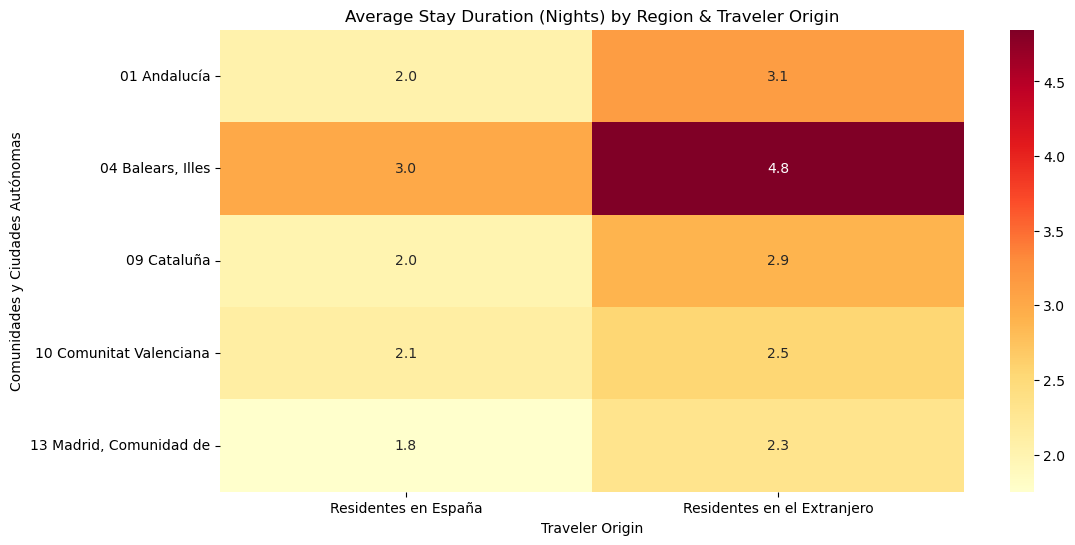

In [60]:
cross_analysis = df_final.pivot_table(
    index='Comunidades y Ciudades Autónomas',
    columns='Traveler Origin',
    values='Avg Stay Duration',
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(cross_analysis, cmap='YlOrRd', annot=True, fmt=".1f")
plt.title("Average Stay Duration (Nights) by Region & Traveler Origin")
plt.show()


    Debido a distintas actualizaciones en los directorios de establecimientos, no son directamente comparables los datos de distintos años. Existen coeficientes de enlace para los períodos: año 2005, junio2009-mayo2010, julio2010-febrero2012.
    Se ha modificado la tabla correspondiente a la publicación de enero de 2007, debido a un error detectado en la provincia de Madrid
    Establecimientos hoteleros: los datos de abril del año 2024 y posteriores son provisionales.
